## Keras TimeseriesGenerator tutorial
Blog - [How to use Keras TimeseriesGenerator for time series data](https://www.dlology.com/blog/how-to-use-keras-timeseriesgenerator-for-time-series-data/)


Keras [TimeseriesGenerator](https://keras.io/preprocessing/sequence/#timeseriesgenerator) API doc

`mpld3` enables zooming of the matplotlib and interactive data visualizations on Jupyter notebook.

Install it with `pip3 install mpld3`

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load DJI, AAPL, AMAZN close index/price
During 2015/09/19-2018/09/18

Downloaded from [YAHOO finance](https://finance.yahoo.com/quote/AMZN/history?period1=1442592000&period2=1537286400&interval=1d&filter=history&frequency=1d).

In [3]:
dataset_DJI = read_csv('./data/DJI_20150919-20180918.csv', usecols=[4]).values.astype('float32')
dataset_AAPL = read_csv('./data/AAPL_20150919-20180918.csv', usecols=[4]).values.astype('float32')
dataset_AMAZN = read_csv('./data/AMZN_20150919-20180918.csv', usecols=[4]).values.astype('float32')

In [4]:
def delta_time_series(data):
    return data[1:]- data[:-1]

In [5]:
dataset_delta_DJI = delta_time_series(dataset_DJI)
dataset_delta_APPL = delta_time_series(dataset_AAPL)
dataset_delta_AMAZN = delta_time_series(dataset_AMAZN)

In [6]:
dataset_DJI.shape

(756, 1)

In [9]:
def plot_delta(data):
    plt.plot(delta_time_series(data))
    plt.ylabel('close')
    plt.show()

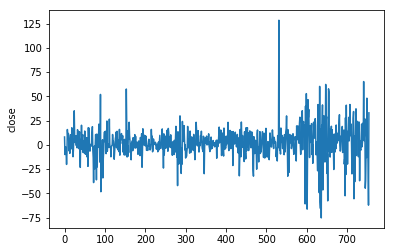

In [10]:
plot_delta(dataset_AMAZN)

### Helper function to get y as a numpy array from the TimeseriesGenerator

In [28]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [40]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)    


## Single time series as input
### Normalize datasets

In [122]:
dataset = dataset_delta_DJI
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [123]:
look_back = 3

In [124]:
train_data_gen = TimeseriesGenerator(train, train,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [125]:
test_data_gen = TimeseriesGenerator(test, test,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)

In [126]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


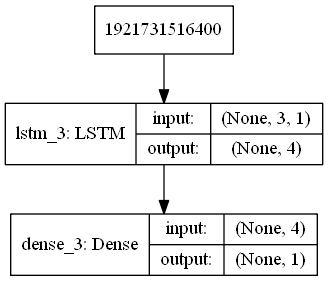

In [127]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [128]:
history = model.fit_generator(train_data_gen, epochs=100).history

Epoch 1/100
168/168 [==============================] - 2s 13ms/step - loss: 0.2233
Epoch 2/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 3/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 4/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 5/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 6/100
168/168 [==============================] - 2s 9ms/step - loss: 0.0048
Epoch 7/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 8/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 9/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 10/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 11/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 12/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 13/100

In [129]:
model.evaluate_generator(test_data_gen)

0.013424654420067732

In [192]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(502, 1)

In [193]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(247, 1)

In [194]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [204]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(502, 1)
(247, 1)


In [205]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [208]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 125.89 RMSE
Test Score: 213.73 RMSE


In [162]:
dataset = scaler.inverse_transform(dataset)
dataset.shape

(755, 1)

In [182]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + dataset_DJI[1:]
# set empty values
# trainPredictPlot[0:look_back, :] = np.nan
# trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan

In [183]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + dataset_DJI[1:]
# set empty values
# testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
# testPredictPlot[len(dataset):, :] = np.nan

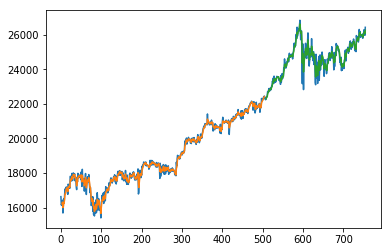

In [184]:
# plot baseline and predictions
plt.plot(dataset + dataset_DJI[1:])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# plot baseline and predictions
plt.plot(dataset + dataset_DJI[:-1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Train with multi-series inputs

In [13]:
dataset_x = np.concatenate((dataset_delta_DJI, dataset_delta_APPL, dataset_delta_AMAZN), axis = 1)
dataset_y = dataset_delta_DJI
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]
train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [14]:
train_x.shape

(505, 3)

In [15]:
train_y.shape

(505, 1)

In [16]:
look_back = 3

In [17]:
train_data_gen = TimeseriesGenerator(train_x, train_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [18]:
test_data_gen = TimeseriesGenerator(test_x, test_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)

In [19]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, train_x.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


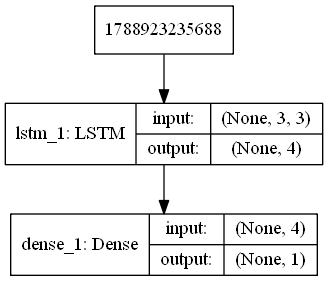

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [228]:
history = model.fit_generator(train_data_gen, epochs=100).history

Epoch 1/100
168/168 [==============================] - 3s 16ms/step - loss: 0.1261
Epoch 2/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 3/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 4/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 5/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 6/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 7/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 8/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 9/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 10/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 11/100
168/168 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 12/100
168/168 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 13/100

In [265]:
model.save('dji_model.h')

In [22]:
from keras.models import load_model
model = load_model('dji_model.h')

In [23]:
model.evaluate_generator(test_data_gen)

0.013383093938651303

In [24]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(502, 1)

In [25]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(247, 1)

In [26]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler_multi.inverse_transform(trainPredict)
testPredict = scaler_multi.inverse_transform(testPredict)
dataset_y = scaler_multi.inverse_transform(dataset_y)

In [29]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)
trainY = scaler_multi.inverse_transform(trainY)
testY = scaler_multi.inverse_transform(testY)

(502, 1)
(247, 1)


In [30]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 125.83 RMSE
Test Score: 213.39 RMSE


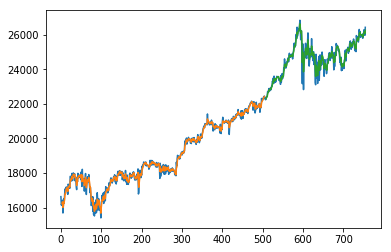

In [35]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + dataset_DJI[1:]


# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_y), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + dataset_DJI[1:]


# plot baseline and predictions
plt.plot(dataset_y + dataset_DJI[1:])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

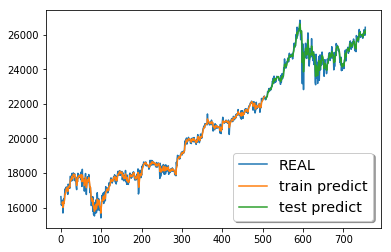

In [51]:
fig, ax = plt.subplots()
ax.plot(dataset_y + dataset_DJI[1:], label='REAL')
ax.plot(trainPredictPlot, label='train predict')
ax.plot(testPredictPlot, label='test predict')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('1')


plt.show()

In [41]:
binary_accuracy(trainY[:,0]>0,  trainPredict[:,0] >0)

0.5398406374501992

In [42]:
binary_accuracy(testY[:,0]>0,  testPredict[:,0] >0)

0.6072874493927125